# Importing data

In [1]:
# libraries needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from difflib import SequenceMatcher
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima  
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

Raw data has been taken from https://sites.google.com/site/notasdecorte/ and should be placed within a folder called "raw_data" in your home directory. Directory where the 12 csv taken from the source should be is '/Users/your_home/raw_data'.

In [2]:
# introduce your home directory, make sure you have created a "raw_data" folder
your_directory = '/Users/miguel'
raw_data_directory = your_directory + '/raw_data'
raw_data_directory

'/Users/miguel/raw_data'

In [3]:
# input raw data from different years (2010-2021)
initial_year = 2010
last_year = 2021
next_year = initial_year + 1
num_years = last_year - initial_year + 1
list_of_dfs = []
list_of_directories = []
# format example: df_2010_2011 = pd.read_csv(raw_data_directory + '/Notas de corte de Medicina 2010_2011 - Hoja 1.csv', decimal = ',')

for i in range(num_years):
    df_name = 'df' + '_' + str(initial_year) + '_' + str(next_year)
    directory = raw_data_directory + '/Notas de corte de Medicina ' + str(initial_year) + '_' + str(next_year) + ' - Hoja 1.csv'
    list_of_dfs.append(df_name)
    list_of_directories.append(directory)
    list_of_dfs[i] = pd.read_csv(list_of_directories[i], decimal = ',')
    
    initial_year += 1
    next_year += 1

In [4]:
# before appending all dfs, we create a column with the year, to keep track of which df/year the data is coming from
initial_year = 2010

for i in range(num_years):
    list_of_dfs[i]['year'] = initial_year + i

In [5]:
# create df
dfs_unified = pd.DataFrame()

In [6]:
# append all the different dfs (12 csv)
for i in range(num_years):
    dfs_unified = dfs_unified.append(list_of_dfs[i])

In [7]:
# check the append has been done correctly: check the number of rows is the sum of all of the dfs

total_number_of_rows = 0

for i in range(num_years):
    total_number_of_rows = total_number_of_rows + len(list_of_dfs[i])

if total_number_of_rows != dfs_unified.shape[0]:
    sys.exit()
else:
    print('append has been done correctly')

append has been done correctly


In [8]:
dfs_unified.describe()

,Nota de corte final de Medicina,1ª Lista,Sobre 10,Sobre 10.1,3ª Lista,Sobre 10.2,4ª Lista,Sobre 10.3,5ª Lista,Sobre 10.4,...,year,Nota de corte final,Nota de corte actual,19ª Lista,20ª Lista,21ª Lista,Sobre 10.20,22ª Lista,23ª Lista,Sobre 10.22
count,31.000000,408.000000,394.000000,391.000000,385.000000,379.000000,366.000000,362.000000,333.000000,331.000000,...,421.000000,32.000000,353.000000,7.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000
mean,11.490484,12.447645,9.041056,8.944463,12.367694,8.900691,12.356454,8.872387,12.356586,8.850885,...,2015.641330,11.870656,12.063295,12.185857,12.518000,12.512333,8.937333,12.505333,12.636000,9.026000
std,0.284092,1.666311,0.290084,0.309839,1.166845,0.316444,1.010194,0.324101,0.813597,0.331569,...,3.467139,0.304269,2.259171,0.376413,0.346221,0.347917,0.248323,0.353030,0.376181,0.268701
min,11.040000,0.201000,8.279000,8.043000,0.175000,8.035000,0.173000,8.007000,0.203000,7.886000,...,2010.000000,11.260000,0.014000,11.852000,12.258000,12.250000,8.750000,12.236000,12.370000,8.836000
25%,11.233000,12.365750,8.841000,8.737000,12.178000,8.700000,12.148000,8.679250,12.133000,8.669500,...,2013.000000,11.693500,12.178000,11.927500,12.321500,12.315000,8.796500,12.305500,12.503000,8.931000
50%,11.496000,12.637500,9.028500,8.952000,12.480000,8.916000,12.444500,8.889000,12.424000,8.874000,...,2016.000000,11.942500,12.449000,12.028000,12.385000,12.380000,8.843000,12.375000,12.636000,9.026000
75%,11.673000,12.909000,9.227000,9.127000,12.723000,9.088500,12.693000,9.066250,12.667000,9.047000,...,2019.000000,12.046000,12.709000,12.325500,12.648000,12.643500,9.031000,12.640000,12.769000,9.121000
max,12.088000,13.580000,9.700000,9.639000,13.450000,9.607000,13.440000,9.600000,13.428000,9.591000,...,2021.000000,12.360000,13.426000,12.915000,12.911000,12.907000,9.219000,12.905000,12.902000,9.216000


# Data Cleaning

## Check for duplicates

In [9]:
if dfs_unified[dfs_unified.duplicated() == True].shape[0] != 0:
    dfs_unified.drop_duplicates()
else:
    print('There are no duplicates')

There are no duplicates


## Create new unique columns out of data that we already had

Since there are consistency issues between the names of the columns in the different data sources, we are going to create new standardized columns

In [10]:
def drop_columns_containing_text(df, text):
    '''
    drop columns that contain a certain string/text
    '''
    df = df[df.columns.drop(list(df.filter(regex=text)))]
    return df

In [11]:
# the column names that containg the string "Sobre" are columns with data ranging from 0-10. We don't want these as we want to keep the scores ranging from 0-14
dfs_unified = drop_columns_containing_text(dfs_unified, 'Sobre')

In [12]:
# to keep track of raw columns, to afterwards drop them
dfs_unified_raw_columns = dfs_unified.columns.tolist()

# "year" was created before and is not a raw column
dfs_unified_raw_columns.remove('year')

In [13]:
def copy_data(new_col, old_col):
    '''
    copy not null data from one column to another
    '''
    dfs_unified[new_col] = np.where(dfs_unified[old_col].notnull(), dfs_unified[old_col], dfs_unified[new_col])

In [14]:
# "university"
dfs_unified['university'] = ''
copy_data('university', 'Notas de corte de Medicina')
copy_data('university', 'Universidad')
copy_data('university', 'Facultad de Medicina')

# "1_list"
dfs_unified['1_list'] = ''
copy_data('1_list', '1ª Lista')

# "final_grade"
dfs_unified['final_grade'] = ''
copy_data('final_grade', 'Nota de corte final de Medicina')
copy_data('final_grade', 'Nota de corte final')
copy_data('final_grade', 'Nota de corte actual')

In [15]:
# drop all old columns
dfs_unified = dfs_unified.drop(dfs_unified_raw_columns, axis=1)

In [16]:
# university column shoud contain a "U". Rows below should be taken out
dfs_unified[~dfs_unified['university'].str.contains('U', na=False)]

,year,university,1_list,final_grade
31,2010,,,
33,2010,"** Publicada nota de 11,257 en la CiuG, el 7/9/10",,
32,2012,Nota promedio,,12.017
33,2012,Desviación típica,,0.22
32,2013,Nota promedio,,12.082
33,2013,Desviación típica,,0.213
32,2014,Nota promedio,,12.268
33,2014,Desviación típica,,0.213
32,2015,Nota promedio,12.605,12.422
33,2015,Desviación típica,0.201,0.188


In [17]:
dfs_unified = dfs_unified[dfs_unified['university'].str.contains('U', na=False)]

In [18]:
# row that was propably used to show additional information we are not interested in
dfs_unified[dfs_unified['university'].str.contains('Sobre la Universidad de Santiago:', na=False)]

,year,university,1_list,final_grade
32,2010,Sobre la Universidad de Santiago:,,


In [19]:
dfs_unified = dfs_unified[~dfs_unified['university'].str.contains('Sobre la Universidad de Santiago:', na=False)]

In [20]:
dfs_unified.columns

Index(['year', 'university', '1_list', 'final_grade'], dtype='object')

In [21]:
dfs_unified_columns = dfs_unified.columns.tolist()[1:]
num_columns = len(dfs_unified_columns)

# replace blanks with NaN
for i in range(num_columns):
    dfs_unified[dfs_unified_columns[i]].replace({'': np.nan}, inplace=True)

## Check for nulls

In [22]:
# quality check: nulls

nulls_1_list = dfs_unified[dfs_unified['1_list'].isnull()].shape[0]
nulls_final_grade = dfs_unified[dfs_unified['final_grade'].isnull()].shape[0]
nulls_university = dfs_unified[dfs_unified['university'].isnull()].shape[0]

if nulls_1_list or nulls_final_grade or nulls_university != 0:
    sys.exit()
else:
    print('column 1_list has', nulls_1_list, 'null rows')
    print('column final_grade has', nulls_final_grade, 'null rows')
    print('column university has', nulls_university, 'null rows')

column 1_list has 0 null rows
column final_grade has 0 null rows
column university has 0 null rows


## Create consistent University names across years

In [23]:
dfs_unified['university'] = dfs_unified['university'].str.lower()

In [24]:
last_year = 2021
dfs_unified[dfs_unified['year'] == last_year]['university'].values

array(['universidad complutense de madrid', 'universidad de sevilla',
       'universidad de murcia', 'universidad de granada',
       'u. autónoma de madrid', 'universidad de málaga',
       'universidad de córdoba', 'universidad de cádiz',
       'u. miguel hernández (s. juan de alicante)',
       'u. de c-la mancha (campus c.real)', 'universidad de alcalá',
       'universidad de valladolid', 'urjc - campus alcorcón',
       'u. de c-la mancha (campus albacete)',
       'u. de extremadura (badajoz)', 'universidad pública de navarra',
       'universidad de valencia', 'universidad jaume i',
       'u. de zaragoza (campus zaragoza)',
       'universidad de barcelona-clínico', 'universidad de la laguna',
       'universidad de las palmas', 'universidad de salamanca',
       'u. de zaragoza (campus huesca)', 'u. de santiago de compostela',
       'universidad de oviedo', 'u. de cantabria (santander)',
       'universidad de barcelona-bellvitge',
       'universidad del país vasco (lejon

We will be using the names of 2021 as a reference

In [25]:
list_of_uni_names_2021 = dfs_unified[dfs_unified['year'] == last_year]['university'].tolist()
num_of_uni_names_2021 = len(list_of_uni_names_2021)
print('There are', num_of_uni_names_2021, 'universities in 2021')

dfs_unified_list_uni = list(dfs_unified['university'].unique())
num_of_uni_names_dataset = len(dfs_unified_list_uni)
print('There are a total of', num_of_uni_names_dataset, 'universities in our dataset')

diff_uni_names = num_of_uni_names_dataset - num_of_uni_names_2021
print('This means there are a total of', diff_uni_names, 'universities that have a different name than the ones in our 2021 data, and need to be mapped')

There are 35 universities in 2021
There are a total of 48 universities in our dataset
This means there are a total of 13 universities that have a different name than the ones in our 2021 data, and need to be mapped


In [26]:
# we create a list with the universities that have different name

list_not_matched = []

for i in dfs_unified_list_uni:
    if i not in list_of_uni_names_2021:
        list_not_matched.append(i)
    else:
        continue


if len(list_not_matched) != diff_uni_names:
    sys.exit()
else:
    print('list of not matched created successfully')

print(list_not_matched)
print(len(list_not_matched))

list of not matched created successfully
['universidad de zaragoza - campus de huesca', 'universidad de cantabria (santander)', 'universidad de santiago de compostela', 'universidad de extremadura (badajoz)', 'universidad pompeu fabra (barcelona)', 'universidad de barcelona', 'universidad de zaragoza - campus de zaragoza', 'universidad de clm- campus de ciudad real', 'universidad de clm- campus de albacete', 'universidad miguel hernández (san juan de alicante)', 'universidad rey juan carlos - campus de alcorcón', 'universidad autónoma de madrid', 'universidad de jaume i']
13


There are 13 universities which have a different name than the ones in 2021 data and need to be mapped. To solve this, we are going to use SequenceMatcher. SequenceMatcher is a class available in python module named “difflib”. It can be used for comparing pairs of input sequences.

### Sequence Matcher

In [27]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [28]:
df_not_matched = pd.DataFrame({
    "not_matched_uni": list_not_matched
})

df_uni_names_2021 = pd.DataFrame({
    "list_of_uni_names_2021": list_of_uni_names_2021
})

df_not_matched_uni_names_2021 = pd.MultiIndex.from_product(
    [df_not_matched["not_matched_uni"], df_uni_names_2021["list_of_uni_names_2021"]], names=["not_matched_uni", "list_of_uni_names_2021"]
).to_frame(index=False)

In [29]:
df_not_matched_uni_names_2021

,not_matched_uni,list_of_uni_names_2021
0,universidad de zaragoza - campus de huesca,universidad complutense de madrid
1,universidad de zaragoza - campus de huesca,universidad de sevilla
2,universidad de zaragoza - campus de huesca,universidad de murcia
3,universidad de zaragoza - campus de huesca,universidad de granada
4,universidad de zaragoza - campus de huesca,u. autónoma de madrid
...,...,...
450,universidad de jaume i,u. pompeu fabra (barcelona)
451,universidad de jaume i,universidad autónoma de barcelona
452,universidad de jaume i,universidad de gerona
453,universidad de jaume i,universidad de lérida


In [30]:
df_not_matched_uni_names_2021['ratio'] = ''

for i in range(len(df_not_matched_uni_names_2021['not_matched_uni'])):
    df_not_matched_uni_names_2021['ratio'][i] = similar(df_not_matched_uni_names_2021['not_matched_uni'][i], df_not_matched_uni_names_2021['list_of_uni_names_2021'][i])

df_not_matched_uni_names_2021['not_matched_uni'].nunique()

13

In [31]:
df_not_matched_uni_names_2021_ratio = df_not_matched_uni_names_2021.groupby('not_matched_uni')['ratio'].max().reset_index()

df_merged = pd.merge(df_not_matched_uni_names_2021_ratio,df_not_matched_uni_names_2021,on='not_matched_uni',how='left')
df_merged = df_merged[df_merged['ratio_x'] == df_merged['ratio_y']]
df_merged

,not_matched_uni,ratio_x,list_of_uni_names_2021,ratio_y
31,universidad autónoma de madrid,0.825397,universidad autónoma de barcelona,0.825397
54,universidad de barcelona,0.857143,universidad de barcelona-clínico,0.857143
96,universidad de cantabria (santander),0.825397,u. de cantabria (santander),0.825397
134,universidad de clm- campus de albacete,0.676056,universidad de las islas baleares,0.676056
140,universidad de clm- campus de ciudad real,0.648649,universidad complutense de madrid,0.648649
189,universidad de extremadura (badajoz),0.825397,u. de extremadura (badajoz),0.825397
227,universidad de jaume i,0.926829,universidad jaume i,0.926829
269,universidad de santiago de compostela,0.830769,u. de santiago de compostela,0.830769
303,universidad de zaragoza - campus de huesca,0.750000,u. de zaragoza (campus huesca),0.75
333,universidad de zaragoza - campus de zaragoza,0.763158,u. de zaragoza (campus zaragoza),0.763158


In [32]:
# replace the not matched university names with the matched ones (there are a few exceptions, not 100% accurate)
dfs_unified['university'] = np.where((dfs_unified['university'] == 'universidad de cantabria (santander)'), 'u. de cantabria (santander)', dfs_unified['university'])
dfs_unified['university'] = np.where((dfs_unified['university'] == 'universidad de extremadura (badajoz)'), 'u. de extremadura (badajoz)', dfs_unified['university'])
dfs_unified['university'] = np.where((dfs_unified['university'] == 'universidad de jaume i'), 'universidad jaume i', dfs_unified['university'])
dfs_unified['university'] = np.where((dfs_unified['university'] == 'universidad de zaragoza - campus de huesca'), 'u. de zaragoza (campus huesca)', dfs_unified['university'])
dfs_unified['university'] = np.where((dfs_unified['university'] == 'universidad de santiago de compostela'), 'u. de santiago de compostela', dfs_unified['university'])
dfs_unified['university'] = np.where((dfs_unified['university'] == 'universidad de zaragoza - campus de zaragoza'), 'u. de zaragoza (campus zaragoza)', dfs_unified['university'])
dfs_unified['university'] = np.where((dfs_unified['university'] == 'universidad miguel hernández (san juan de alicante)'), 'u. miguel hernández (s. juan de alicante)', dfs_unified['university'])
dfs_unified['university'] = np.where((dfs_unified['university'] == 'universidad pompeu fabra (barcelona)'), 'u. pompeu fabra (barcelona)', dfs_unified['university'])
dfs_unified['university'] = np.where((dfs_unified['university'] == 'universidad de santiago de compostela'), 'u. de santiago de compostela', dfs_unified['university'])
dfs_unified['university'] = np.where((dfs_unified['university'] == 'universidad rey juan carlos - campus de alcorcón'), 'urjc - campus alcorcón', dfs_unified['university'])
dfs_unified['university'] = np.where((dfs_unified['university'] == 'universidad autónoma de madrid'), 'u. autónoma de madrid', dfs_unified['university'])
dfs_unified['university'] = np.where((dfs_unified['university'] == 'universidad de barcelona'), 'universidad de barcelona-clínico', dfs_unified['university'])
dfs_unified['university'] = np.where((dfs_unified['university'] == 'universidad de clm- campus de albacete'), 'u. de c-la mancha (campus albacete)', dfs_unified['university'])
dfs_unified['university'] = np.where((dfs_unified['university'] == 'universidad de clm- campus de ciudad real'), 'u. de c-la mancha (campus c.real)', dfs_unified['university'])

In [33]:
# quality check: make sure all university names are mapped with 2021 names

dfs_unified_list_uni = list(dfs_unified['university'].unique())

list_not_matched = []

for i in dfs_unified_list_uni:
    if i not in list_of_uni_names_2021:
        list_not_matched.append(i)
    else:
        continue

# checking length of not matched
if len(list_not_matched) != 0:
    sys.exit()
else:
    print('all university names are consistent with 2021')

# another way of checking this could be by analyzing the overall length and unique names
if dfs_unified['university'].nunique() != len(list_of_uni_names_2021):
    sys.exit()
else:
    print('all university names are consistent with 2021')

all university names are consistent with 2021
all university names are consistent with 2021


### Check if all of the universities have been teaching the Medicine career since 2010

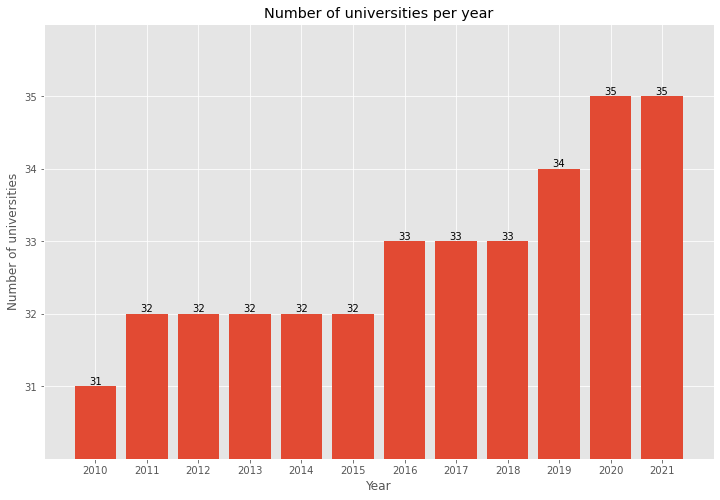

In [34]:
# check how many universities there are per year
uni_year_grouped = dfs_unified.groupby(['year'])['university'].count().reset_index()

# style
plt.style.use('ggplot')

fig,ax=plt.subplots(figsize=(12,8))
bars = ax.bar(uni_year_grouped['year'], uni_year_grouped['university'])
# show number on top of bars
ax.bar_label(bars)

# title and axis
plt.xticks(range(min(uni_year_grouped['year']), max(uni_year_grouped['year']) + 1))
plt.yticks(range(min(uni_year_grouped['university']), max(uni_year_grouped['university']) + 1))
plt.axis([2009, 2022, 30, 36])
plt.title('Number of universities per year')
plt.xlabel('Year')
plt.ylabel('Number of universities')

plt.show()

In [35]:
# seems like there are 4 universities that haven't been teaching the Medicine career since 2010, let's check which ones they are
bool_2010 = {'since_2010': dfs_unified.groupby('university')['university'].count() == 12}
bool_2010_df = pd.DataFrame(bool_2010, columns=['since_2010'])
bool_2010_df[bool_2010_df['since_2010'] == False]

,since_2010
university,
universidad de barcelona-bellvitge,False
universidad de las islas baleares,False
universidad jaume i,False
universidad pública de navarra,False


In [36]:
# year since they have been teaching it
year_uni_bb = dfs_unified[dfs_unified['university'] == 'universidad de barcelona-bellvitge']['year'].min()
year_uni_ib = dfs_unified[dfs_unified['university'] == 'universidad de las islas baleares']['year'].min()
year_uni_ji = dfs_unified[dfs_unified['university'] == 'universidad jaume i']['year'].min()
year_uni_pn = dfs_unified[dfs_unified['university'] == 'universidad pública de navarra']['year'].min()
print('universidad de barcelona-bellvitge: ', year_uni_bb)
print('universidad de las islas baleares: ', year_uni_ib)
print('universidad jaume i: ', year_uni_ji)
print('universidad pública de navarra: ', year_uni_pn)

universidad de barcelona-bellvitge:  2020
universidad de las islas baleares:  2016
universidad jaume i:  2011
universidad pública de navarra:  2019


# Feature Engineering

## Since_2010 column

Indicates whether the university has been teaching the medicine career since 2010 or not. In case it does, value of this column is “True”. If not, the value will be the year from which that university has been teaching the career

In [37]:
# we create a function so that we can apply it later to the predicted 2022 data
def since_2010():
    dfs_unified['since_2010'] = ''
    dfs_unified['since_2010'] = np.where(dfs_unified['university'] == 'universidad de barcelona-bellvitge', year_uni_bb, dfs_unified['since_2010'])
    dfs_unified['since_2010'] = np.where(dfs_unified['university'] == 'universidad de las islas baleares', year_uni_ib, dfs_unified['since_2010'])
    dfs_unified['since_2010'] = np.where(dfs_unified['university'] == 'universidad jaume i', year_uni_ji, dfs_unified['since_2010'])
    dfs_unified['since_2010'] = np.where(dfs_unified['university'] == 'universidad pública de navarra', year_uni_pn, dfs_unified['since_2010'])
    dfs_unified['since_2010'] = np.where(dfs_unified['since_2010'] == '', True, dfs_unified['since_2010'])

In [38]:
since_2010()

In [39]:
dfs_unified['since_2010'].nunique()

5

In [40]:
dfs_unified[dfs_unified['since_2010'] != True]

,year,university,1_list,final_grade,since_2010
10,2011,universidad jaume i,12.332,11.730,2011
12,2012,universidad jaume i,12.440,11.944,2011
10,2013,universidad jaume i,12.334,11.931,2011
11,2014,universidad jaume i,12.422,12.118,2011
9,2015,universidad jaume i,12.574,12.320,2011
1,2016,universidad de las islas baleares,12.534,12.144,2016
12,2016,universidad jaume i,12.754,12.376,2011
2,2017,universidad de las islas baleares,12.744,12.112,2016
18,2017,universidad jaume i,12.780,12.464,2011
0,2018,universidad de las islas baleares,12.568,12.120,2016


## Create City and CCAA columns

### City

In [41]:
list_of_cities = ['madrid', 'zaragoza', 'barcelona', 'sevilla', 'valencia', 'murcia', 'granada','málaga', 'córdoba', 'cádiz', 'alicante', 'albacete', \
    'valladolid', 'badajoz', 'gerona', 'lérida', 'reus', 'navarra', 'santander', 'oviedo', \
    'santiago de compostela', 'salamanca', 'bilbao', 'salamanca', 'navarra', 'las palmas', 'la laguna', 'alcalá', 'ciudad real', 'huesca']

num_cities = len(list_of_cities)

In [42]:
# we create a function so that we can apply it later to the predicted 2022 data

def city():
    ''' 
    creates city column
    values are the city name found on the university name
    '''
    i=0
    dfs_unified['city'] = ''
    while i < num_cities:
        dfs_unified['city'] = np.where(dfs_unified['university'].str.contains(list_of_cities[i], na=False), list_of_cities[i], dfs_unified['city'])
        i +=1
    # do not contain the city name
    dfs_unified['city'] = np.where(dfs_unified['university'].str.contains('país vasco', na=False), 'bilbao', dfs_unified['city'])
    dfs_unified['city'] = np.where(dfs_unified['university'].str.contains('alcorcón', na=False), 'madrid', dfs_unified['city'])
    dfs_unified['city'] = np.where(dfs_unified['university'].str.contains('c.real', na=False), 'ciudad real', dfs_unified['city'])
    dfs_unified['city'] = np.where(dfs_unified['university'].str.contains('jaume', na=False), 'castellon de la plana', dfs_unified['city'])
    dfs_unified['city'] = np.where(dfs_unified['university'].str.contains('islas baleares', na=False), 'palma de mallorca', dfs_unified['city'])

    num_columns = len(dfs_unified_columns)

    while i < num_columns:
        dfs_unified[dfs_unified_columns[i]].replace({'': np.nan}, inplace=True)
        i += 1

In [43]:
city()

In [44]:
dfs_unified[dfs_unified['city'].isnull()]

,year,university,1_list,final_grade,since_2010,city


### CCAA - Autonomous Communities of Spain

In [45]:
# CCAA - communities
def CCAA():
    '''
    creates Autonomous Communities of Spain field based on the city
    '''
    dfs_unified['CCAA'] = ''
    dfs_unified['CCAA'] = np.where(dfs_unified['city'].isin(['huesca', 'zaragoza']), 'Aragón', dfs_unified['CCAA'])
    dfs_unified['CCAA'] = np.where(dfs_unified['city'].isin(['lérida', 'gerona', 'reus', 'barcelona']), 'Cataluña', dfs_unified['CCAA'])
    dfs_unified['CCAA'] = np.where(dfs_unified['city'].isin(['madrid', 'alcalá']), 'C. Madrid', dfs_unified['CCAA'])
    dfs_unified['CCAA'] = np.where(dfs_unified['city'].isin(['valladolid', 'salamanca']), 'Castilla y León', dfs_unified['CCAA'])
    dfs_unified['CCAA'] = np.where(dfs_unified['city'].isin(['santander']), 'Cantabria', dfs_unified['CCAA'])
    dfs_unified['CCAA'] = np.where(dfs_unified['city'].isin(['santiago de compostela']), 'Galicia', dfs_unified['CCAA'])
    dfs_unified['CCAA'] = np.where(dfs_unified['city'].isin(['badajoz']), 'Extremadura', dfs_unified['CCAA'])
    dfs_unified['CCAA'] = np.where(dfs_unified['city'].isin(['cádiz', 'córdoba', 'sevilla', 'málaga', 'granada']), 'Andalucía', dfs_unified['CCAA'])
    dfs_unified['CCAA'] = np.where(dfs_unified['city'].isin(['murcia']), 'Murcia', dfs_unified['CCAA'])
    dfs_unified['CCAA'] = np.where(dfs_unified['city'].isin(['ciudad real', 'albacete']), 'Castilla-La Mancha', dfs_unified['CCAA'])
    dfs_unified['CCAA'] = np.where(dfs_unified['city'].isin(['bilbao']), 'País Vasco', dfs_unified['CCAA'])
    dfs_unified['CCAA'] = np.where(dfs_unified['city'].isin(['la laguna', 'las palmas']), 'Canarias', dfs_unified['CCAA'])
    dfs_unified['CCAA'] = np.where(dfs_unified['city'].isin(['valencia', 'castellon de la plana', 'alicante']), 'C. Valenciana', dfs_unified['CCAA'])
    dfs_unified['CCAA'] = np.where(dfs_unified['city'].isin(['oviedo']), 'Asturias', dfs_unified['CCAA'])
    dfs_unified['CCAA'] = np.where(dfs_unified['city'].isin(['palma de mallorca']), 'Islas Baleares', dfs_unified['CCAA'])
    dfs_unified['CCAA'] = np.where(dfs_unified['city'].isin(['navarra']), 'Navarra', dfs_unified['CCAA'])

In [46]:
CCAA()

In [47]:
dfs_unified[dfs_unified['CCAA'] == '']

,year,university,1_list,final_grade,since_2010,city,CCAA


In [48]:
dfs_unified['CCAA'].unique()

array(['Cataluña', 'Aragón', 'Castilla y León', 'Cantabria', 'Galicia',
       'Extremadura', 'Andalucía', 'Castilla-La Mancha', 'País Vasco',
       'C. Valenciana', 'C. Madrid', 'Murcia', 'Canarias', 'Asturias',
       'Islas Baleares', 'Navarra'], dtype=object)

## Difference of 1_list and final_grade scores between years

In [49]:
def diff_between_years(field_name, score):
    ''' 
    difference of a score column between the current year and the previous year. For year 2010, this column’s value is NaN since we don’t have data from the previous year (2009)
    '''
    dfs_unified[field_name] = ''

    # year 2010 (initial year)
    for uni in list_of_uni_names_2021:
        dfs_unified[field_name] = np.where((dfs_unified['university'] == uni) & (dfs_unified['year'] == 2010), np.nan, dfs_unified[field_name])
    # rest of years
    for uni in list_of_uni_names_2021:
        for year in range(2011, 2023):
            try:
                dfs_unified[field_name] = np.where((dfs_unified['university'] == uni) & (dfs_unified['year'] == year), float((dfs_unified[(dfs_unified['university'] == uni) & (dfs_unified['year'] == year)][score]).values[0] - (dfs_unified[(dfs_unified['university'] == uni) & (dfs_unified['year'] == year - 1)][score]).values[0]), dfs_unified[field_name])
            except:
                pass

    # for the 4 universities that don't have data since 2010
    dfs_unified[field_name].replace({'': np.nan}, inplace=True)

In [50]:
diff_between_years('diff_1_list', '1_list')

In [51]:
diff_between_years('diff_final_grade', 'final_grade')

## Decreased value between 1_list and final_grade

In [52]:
# decresead value from 1_list to final grade
def diff_1_list_final_grade():
    '''
    difference between the 1_list and final_grade columns for the current year
    '''
    dfs_unified['diff_1_list_final_grade'] = dfs_unified['1_list'] - dfs_unified['final_grade']

In [53]:
diff_1_list_final_grade()

## Covid format change: change in test format due to covid

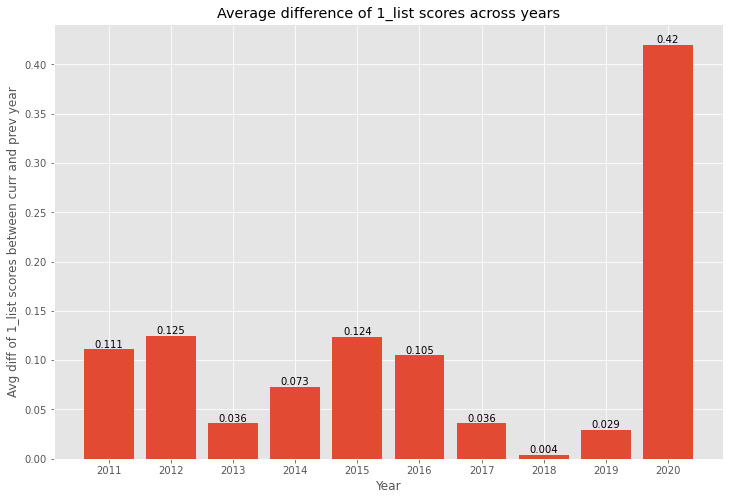

average 1_list difference before 2020 is:  0.07144444444444445
average 1_list difference in 2020 is:  0.42
The difference between average before 2020 and average in 2020 is x 5.87869362363919


In [54]:
# compare 1_list growth of years before 2020, and in 2020
grouped_year_1_list = dfs_unified.groupby('year')['diff_1_list'].mean().reset_index()

# round to 3 decimals
grouped_year_1_list['diff_1_list'] = grouped_year_1_list['diff_1_list'].apply(lambda x: round(x, 3))

# since we don't have data from 2009, we are excluding 2010
# we are also excluding 2021 since it's not relevant to show the growth before and after covid
grouped_year_1_list = grouped_year_1_list[(grouped_year_1_list['year'] != 2010) & (grouped_year_1_list['year'] != 2021)]

grouped_year_1_list_before_2020 = grouped_year_1_list[grouped_year_1_list['year'] < 2020]
grouped_year_1_list_in_2020 = grouped_year_1_list[grouped_year_1_list['year'] == 2020]


fig,ax=plt.subplots(figsize=(12,8))
bars = ax.bar(grouped_year_1_list['year'], grouped_year_1_list['diff_1_list'])
# show number on top of bars
ax.bar_label(bars)
# style
plt.style.use('ggplot')
# title and axis
plt.xticks(range(min(grouped_year_1_list['year']), max(grouped_year_1_list['year']) + 1))
plt.title('Average difference of 1_list scores across years')
plt.xlabel('Year')
plt.ylabel('Avg diff of 1_list scores between curr and prev year')

plt.show()


print('average 1_list difference before 2020 is: ', grouped_year_1_list_before_2020['diff_1_list'].mean())
print('average 1_list difference in 2020 is: ',grouped_year_1_list_in_2020['diff_1_list'].mean())
print('The difference between average before 2020 and average in 2020 is x',grouped_year_1_list_in_2020['diff_1_list'].mean() / grouped_year_1_list_before_2020['diff_1_list'].mean())

In [55]:
# change in test format due to covid

def covid_format_change():
    ''' 
    creates covid_format_change column
    this field has two different values, 1 if the year is >= 2020 and 0 if it’s < 2020
    '''
    dfs_unified['covid_format_change'] = ''
    dfs_unified['covid_format_change'] = np.where((dfs_unified['year'] >= 2020), float(1), dfs_unified['covid_format_change'])
    dfs_unified['covid_format_change'] = np.where((dfs_unified['year'] < 2020), float(0), dfs_unified['covid_format_change'])

In [56]:
covid_format_change()

## Round columns above to 3 decimals

In [57]:
def round_to_3():
    ''' 
    round numbers in columns "1_list", "final_grade", "diff_final_grade", "diff_1_list" and "diff_1_list_final_grade" to 3 decimals
    '''
    dfs_unified['1_list'] = dfs_unified['1_list'].apply(lambda x: round(x, 3))
    dfs_unified['final_grade'] = dfs_unified['final_grade'].apply(lambda x: round(x, 3))
    dfs_unified['diff_final_grade'] = dfs_unified['diff_final_grade'].apply(lambda x: round(x, 3))
    dfs_unified['diff_1_list'] = dfs_unified['diff_1_list'].apply(lambda x: round(x, 3))
    dfs_unified['diff_1_list_final_grade'] = dfs_unified['diff_1_list_final_grade'].apply(lambda x: round(x, 3))

In [58]:
round_to_3()

## Shorter name of universities

In [59]:
dfs_unified['university'] = dfs_unified['university'].replace('universidad', 'u.', regex=True)
list_of_uni_names_2021  = dfs_unified[dfs_unified['year'] == last_year]['university'].tolist()

## Latitude and Longitude of Universities for map on Streamlit

In [60]:
#https://www.mapcoordinates.net/es

def latitude():
    ''' 
    latitude corresponding to the university
    '''
    dfs_unified['latitude'] = ''
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. autónoma de barcelona', 41.5025932, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de lérida', 41.81636125, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de gerona', 41.9743792, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. rovira i virgili (reus)', 41.155309, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de zaragoza (campus huesca)', 42.1414059, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de valladolid', 41.6105937, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de cantabria (santander)', 43.4736983, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de santiago de compostela', 42.88050025, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de extremadura (badajoz)', 38.8824069, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de cádiz', 36.5340199, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. pompeu fabra (barcelona)', 41.37921475, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de barcelona-clínico', 41.39017434, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de salamanca', 40.9666432, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de zaragoza (campus zaragoza)', 41.6421312, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de c-la mancha (campus c.real)', 38.9918372, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de córdoba', 37.8560421, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. del país vasco (lejona)', 43.3359821, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de c-la mancha (campus albacete)', 38.4527362, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de sevilla', 37.4128557, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. miguel hernández (s. juan de alicante)', 38.39896277, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de alcalá', 40.4818396, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de málaga', 36.7200431, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de murcia', 37.99109245, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de la laguna', 28.4852475, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'urjc - campus alcorcón', 40.3506324, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de valencia', 39.4786642, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. autónoma de madrid', 40.4832261, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de las palmas', 28.09055808, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de granada', 37.1474408, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. complutense de madrid', 40.4437398, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de oviedo', 43.3533657, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. jaume i', 39.9899483, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de las islas baleares', 39.60701435, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. pública de navarra', 42.8154264, dfs_unified['latitude'])
    dfs_unified['latitude'] = np.where(dfs_unified['university'] == 'u. de barcelona-bellvitge', 41.3507816, dfs_unified['latitude'])

In [61]:
def longitude():
    ''' 
    longitude corresponding to the university
    '''
    dfs_unified['longitude'] = ''
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. autónoma de barcelona', 2.080056, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de lérida', 1.59713745, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de gerona', 2.8235429, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. rovira i virgili (reus)', 1.1053273, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de zaragoza (campus huesca)', -0.4060896, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de valladolid', -4.6916619, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de cantabria (santander)', -3.7859174, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de santiago de compostela', -8.5457602, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de extremadura (badajoz)', -7.0194457, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de cádiz', -6.3018987, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. pompeu fabra (barcelona)', 2.17941527, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de barcelona-clínico', 2.15212588, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de salamanca', -5.6772757, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de zaragoza (campus zaragoza)', -0.90302271, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de c-la mancha (campus c.real)', -3.9268263, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de córdoba', -4.8134452, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. del país vasco (lejona)', -2.9768285, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de c-la mancha (campus albacete)', -2.05363374, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de sevilla', -5.9845606, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. miguel hernández (s. juan de alicante)', -0.43477806, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de alcalá', -3.3644973, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de málaga', -4.41617939, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de murcia', -1.13010405, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de la laguna', -16.3126059, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'urjc - campus alcorcón', -3.8437926, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de valencia', -0.3627246, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. autónoma de madrid', -3.6972262, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de las palmas', -15.41890014, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de granada', -3.6042349, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. complutense de madrid', -3.72614639, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de oviedo', -5.8687712, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. jaume i', -0.0664218, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de las islas baleares', 2.64475448, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. pública de navarra', -1.65263107, dfs_unified['longitude'])
    dfs_unified['longitude'] = np.where(dfs_unified['university'] == 'u. de barcelona-bellvitge', 2.1045067, dfs_unified['longitude'])

In [62]:
latitude()
longitude()

In [63]:
dfs_unified[dfs_unified['latitude'] == '']

,year,university,1_list,final_grade,since_2010,city,CCAA,diff_1_list,diff_final_grade,diff_1_list_final_grade,covid_format_change,latitude,longitude


In [64]:
dfs_unified[dfs_unified['longitude'] == '']

,year,university,1_list,final_grade,since_2010,city,CCAA,diff_1_list,diff_final_grade,diff_1_list_final_grade,covid_format_change,latitude,longitude


In [65]:
dfs_unified[dfs_unified['latitude'].isnull()]

,year,university,1_list,final_grade,since_2010,city,CCAA,diff_1_list,diff_final_grade,diff_1_list_final_grade,covid_format_change,latitude,longitude


In [66]:
dfs_unified[dfs_unified['longitude'].isnull()]

,year,university,1_list,final_grade,since_2010,city,CCAA,diff_1_list,diff_final_grade,diff_1_list_final_grade,covid_format_change,latitude,longitude


# Modelling

In [67]:
dfs_unified.head()

,year,university,1_list,final_grade,since_2010,city,CCAA,diff_1_list,diff_final_grade,diff_1_list_final_grade,covid_format_change,latitude,longitude
0,2010,u. de lérida,11.654,11.040,True,lérida,Cataluña,NaN,NaN,0.614,0.0,41.816361,1.597137
1,2010,u. de gerona,11.610,11.070,True,gerona,Cataluña,NaN,NaN,0.540,0.0,41.974379,2.823543
2,2010,u. rovira i virgili (reus),11.708,11.142,True,reus,Cataluña,NaN,NaN,0.566,0.0,41.155309,1.105327
3,2010,u. de zaragoza (campus huesca),12.059,11.190,True,huesca,Aragón,NaN,NaN,0.869,0.0,42.141406,-0.40609
4,2010,u. autónoma de barcelona,11.590,11.195,True,barcelona,Cataluña,NaN,NaN,0.395,0.0,41.502593,2.080056


In [68]:
dfs_unified_columns

['university', '1_list', 'final_grade']

In [69]:
# for the Modelling section, columns that contain scores ("1_list" and "final_grade") have to have the NaN scores replaced by 0, to avoid errors
dfs_unified_columns = dfs_unified.columns.tolist()[1:]

num_columns = len(dfs_unified_columns)

for i in range(num_columns):
    dfs_unified[dfs_unified_columns[i]].replace({np.nan: 0}, inplace=True)

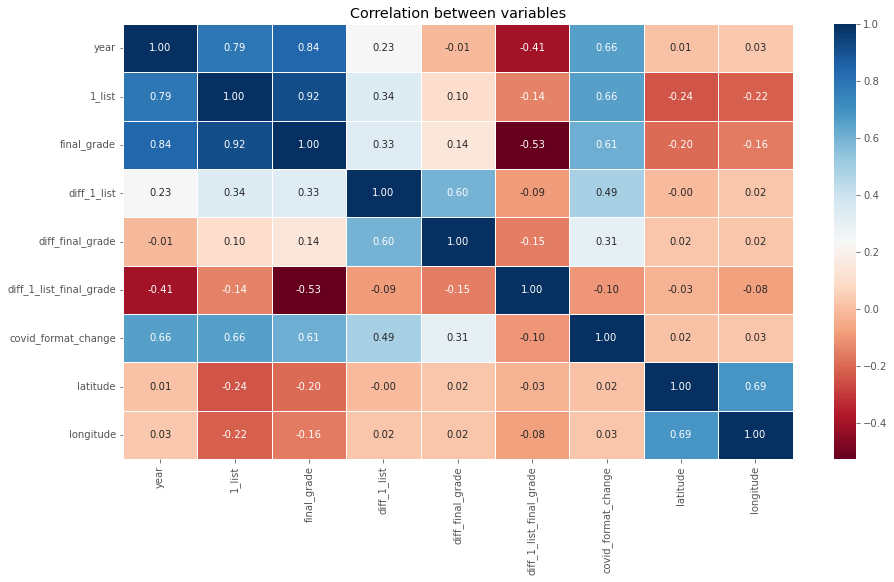

In [70]:
fig, ax = plt.subplots(figsize=(15,8))         # Sample figsize in inches
sns.heatmap(dfs_unified.corr(), annot=True, fmt=".2f", linewidths=.5, ax=ax, cmap='RdBu')
plt.title('Correlation between variables');

## Create and evaluate models

As the output variable "1_list" is a number we need to solve a regression problem.

In this section we will be using as training data the years 2010 and 2012-2020, as validation the year 2011 and the year 2021 as test data.

### Linear Regression

In [71]:
def plot_actual_vs_predicted(title_string, subtitle_string, y_test, y_predict, year):
    ''' 
    visualize the predicted score as a line on the test set
    '''
    plt.figure(figsize=(12,6))
    plt.scatter(dfs_unified[dfs_unified['year'] == year]['university'], y_test, color = 'red', label = 'actual')
    plt.plot(dfs_unified[dfs_unified['year'] == year]['university'], y_predict, color='g', label = 'predicted')
    plt.xlabel('University', fontsize = 14)
    plt.ylabel('1_list', fontsize = 14)
    plt.xticks(rotation=90)
    plt.suptitle(title_string, y=1.05, fontsize=18)
    plt.title(subtitle_string, fontsize=16)
    plt.legend()
    plt.style.use('ggplot')
    plt.show()

In [72]:
# create df to keep track of metrics
results_models = pd.DataFrame(columns=['model_name_variables', 'MSE', 'RMSE', 'MAE'])

In [73]:
def plot_metrics():
    ''' 
    plot MSE, RMSE and MAE metrics in horizontal bar charts
    '''
    plt.style.use('ggplot')

    df_MSE = results_models[['MSE']]
    df_RMSE = results_models[['RMSE']]
    df_MAE = results_models[['MAE']]

    # sort values so the best model appears in first position
    df_MSE = df_MSE.sort_values('MSE', ascending=False)
    df_RMSE = df_RMSE.sort_values('RMSE', ascending=False)
    df_MAE = df_MAE.sort_values('MAE', ascending=False)

    # create figure and one axis per metric
    f = plt.figure(figsize=(10,20))
    axes1 = f.add_subplot(4,1,1)
    axes2 = f.add_subplot(4,1,2)
    axes3 = f.add_subplot(4,1,3)
        
    # plot dataframes with DataFrame.plot()
    df_MSE.plot(kind='barh', ax=axes1, color='lightgreen', title = 'Compare Model Metrics')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    df_RMSE.plot(kind='barh', ax=axes2, color='lightskyblue')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    df_MAE.plot(kind='barh',ax=axes3, color='salmon')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))  
        
    # annotate bars with result values 
    for p in axes1.patches:
            axes1.annotate(np.round(a=p.get_width(), decimals=3), \
                    (p.get_x() + p.get_width(), p.get_y()), \
                    xytext=(-30, 5), textcoords='offset points')

    for p in axes2.patches:
            axes2.annotate(np.round(a=p.get_width(), decimals=3), \
                    (p.get_x() + p.get_width(), p.get_y()), \
                    xytext=(-30, 5), textcoords='offset points')

    for p in axes3.patches:
            axes3.annotate(np.round(a=p.get_width(), decimals=3), \
                    (p.get_x() + p.get_width(), p.get_y()), \
                    xytext=(-30, 5), textcoords='offset points')
    plt.show()

In [74]:
def linear_regression(X_var, model_name_variables):
    ''' 
    create Linear Regression model
    evaluate model with metrics MSE, RMSE, MAE
    plot actual vs predicted values
    '''
    lr = LinearRegression()

    X_train = dfs_unified[(dfs_unified['year'] != 2021) & (dfs_unified['year'] != 2011)][X_var]
    y_train = dfs_unified[(dfs_unified['year'] != 2021) & (dfs_unified['year'] != 2011)][['1_list']]

    X_test = dfs_unified[(dfs_unified['year'] == 2021)][X_var]
    y_test = dfs_unified[(dfs_unified['year'] == 2021)][['1_list']]

    lr.fit(X_train, y_train)

    y_predict = lr.predict(X_test) # we are predicting the 1_list scores for 2021, for all of the universities (various scores)
    
    
    # evaluation
    errors = y_test - y_predict

    # MSE (min squared error)
    mse = float(np.mean(errors ** 2))

    # RMSE (root min squared error)
    rmse = float(np.sqrt(mse))

    # MAE (mean absolute error)
    mae = float(np.mean(np.abs(errors)))
    
    results_models.loc[model_name_variables] = [model_name_variables, mse, rmse, mae]

    plot_actual_vs_predicted('Linear Regression: For 2021, actual 1_list scores vs predicted', f'Variables: {X_var}', y_test, y_predict, 2021)

    

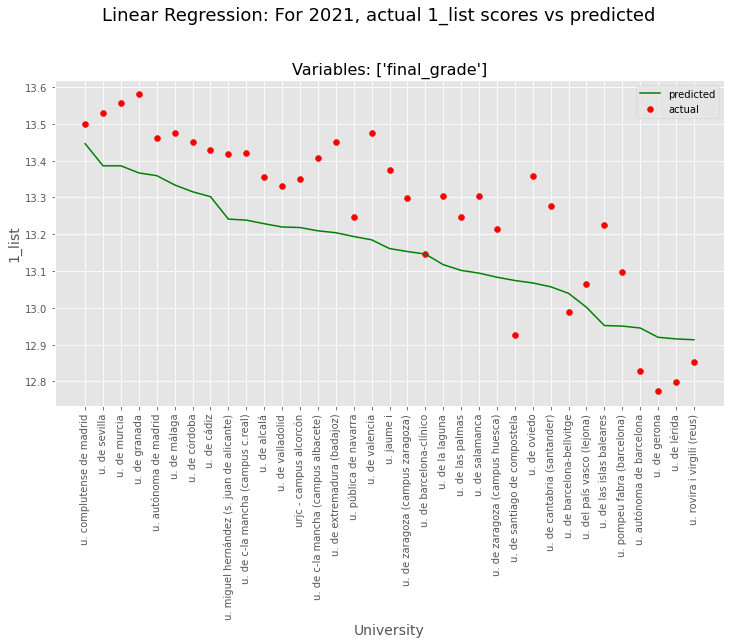

In [75]:
# using only "final_grade" variable

linear_regression(['final_grade'], 'linear_regression_final_grade')

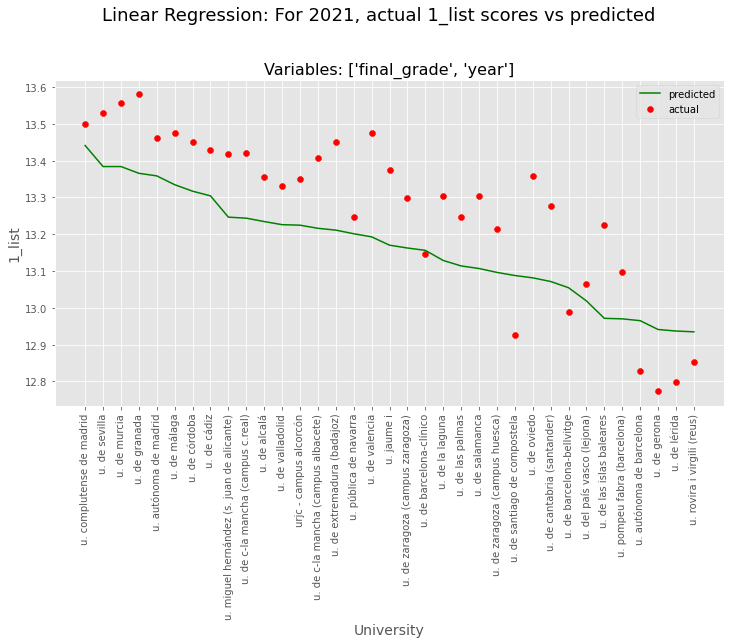

In [76]:
# using "final_grade" and "year" variables
linear_regression(['final_grade', 'year'], 'linear_regression_final_grade_year')

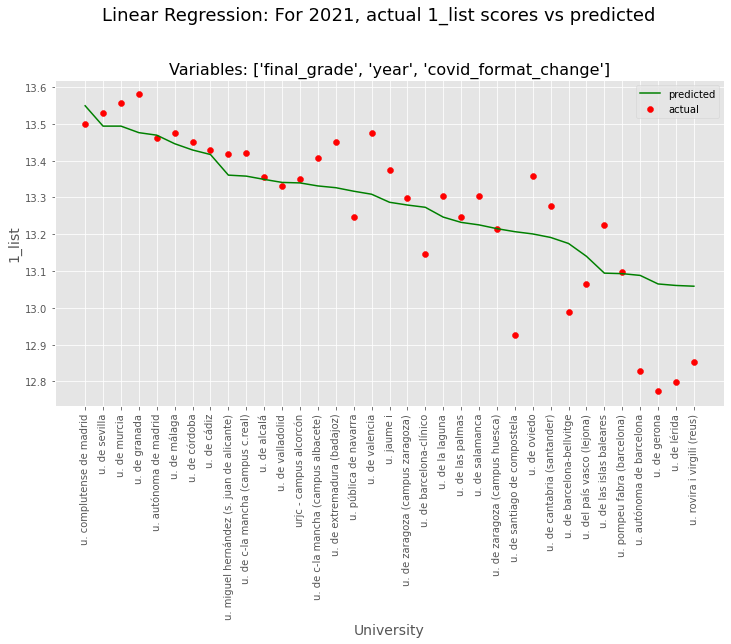

In [77]:
# using "final_grade", "year" and "covid_format_change" variables
linear_regression(['final_grade', 'year', 'covid_format_change'], 'linear_regression_final_grade_year_covid')

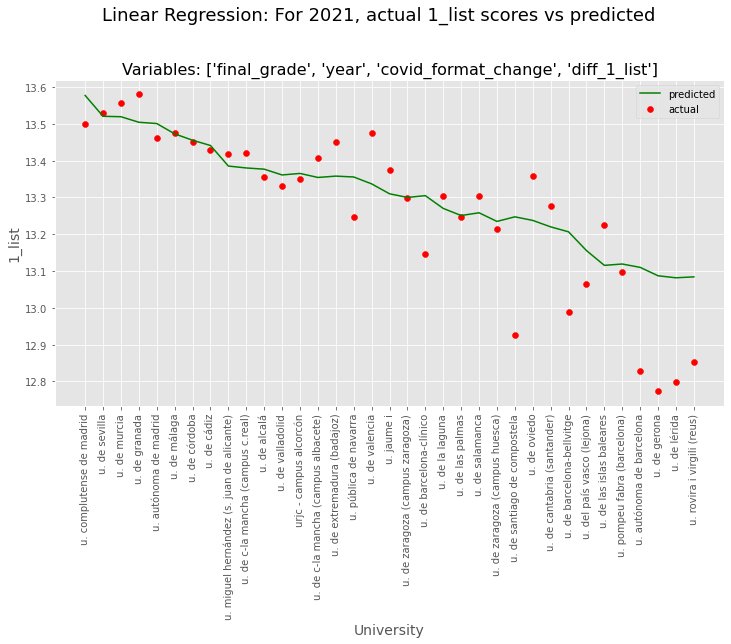

In [78]:
# using "final_grade", "year", "covid_format_change" and "diff_1_list"  variables
linear_regression(['final_grade', 'year', 'covid_format_change', 'diff_1_list'], 'linear_regression_final_grade_year_covid_diff_1_list')

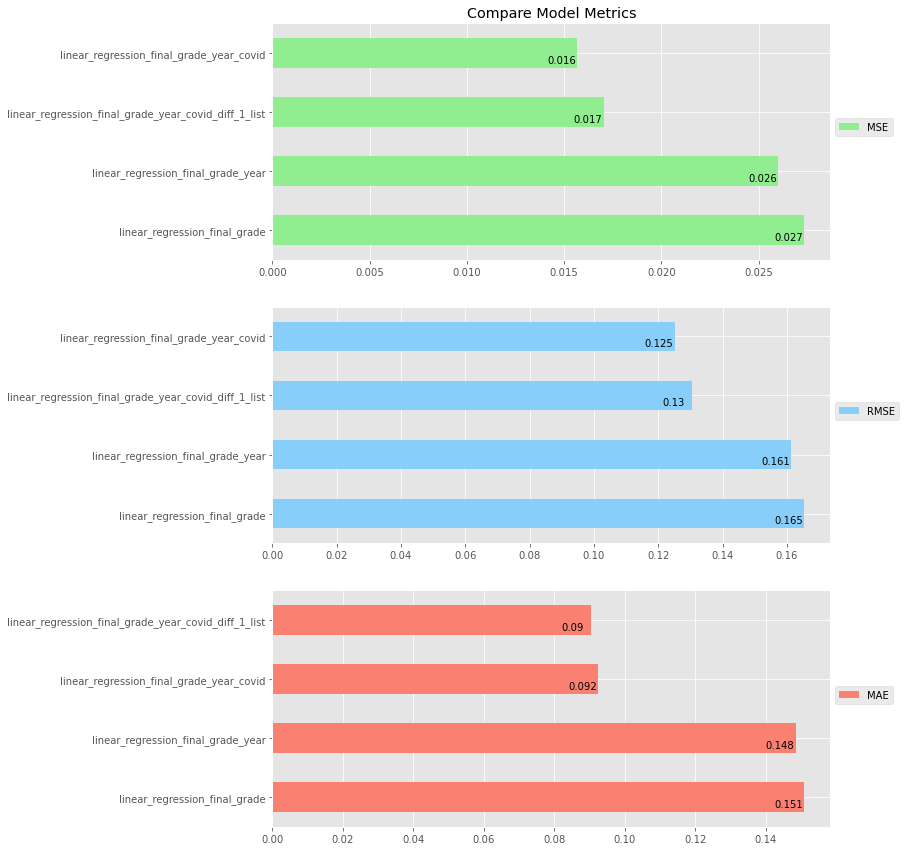

In [79]:
plot_metrics()

### Linear Regression per University

In [80]:
# df to keep track of metrics of the different Linear Regression models (one per university)
results_models_per_uni = pd.DataFrame(columns=['university','MSE', 'RMSE', 'MAE', 'y_predict', 'y_test'])
results_models_per_uni['university'] = list_of_uni_names_2021

In [81]:
def linear_regression_per_uni(X_var, model_name_variables, target_year):
    ''' 
    create Linear Regression model per university
    evaluate model with metrics MSE, RMSE, MAE
    '''

    lr = LinearRegression()
    X_train = dfs_unified[(dfs_unified['university'] == uni) & (dfs_unified['year'] != 2021) & (dfs_unified['year'] != 2011)][X_var]
    y_train = dfs_unified[(dfs_unified['university'] == uni) & (dfs_unified['year'] != 2021) & (dfs_unified['year'] != 2011)][['1_list']]

    X_test = dfs_unified[(dfs_unified['university'] == uni) & (dfs_unified['year'] == target_year)][X_var]
    y_test = dfs_unified[(dfs_unified['university'] == uni) & (dfs_unified['year'] == target_year)][['1_list']]

    lr.fit(X_train, y_train)

    y_predict = lr.predict(X_test) # we are predicting the 1_list score from 2021 for a specific university (only 1 score)
    y_predict = float(y_predict)
    y_test = y_test['1_list'].values[0]

    # evaluation
    errors = y_test - y_predict

    # MSE (min squared error)
    mse = np.mean(errors ** 2)

    # RMSE (root min squared error)
    rmse = np.sqrt(mse)

    # MAE (mean absolute error)
    mae = np.mean(np.abs(errors))
    
    results_models_per_uni['MSE'] = np.where(results_models_per_uni['university'] == uni, mse, results_models_per_uni['MSE'])
    results_models_per_uni['RMSE'] = np.where(results_models_per_uni['university'] == uni, rmse, results_models_per_uni['RMSE'])
    results_models_per_uni['MAE'] = np.where(results_models_per_uni['university'] == uni, mae, results_models_per_uni['MAE'])
    results_models_per_uni['y_predict'] = np.where(results_models_per_uni['university'] == uni, y_predict, results_models_per_uni['y_predict'])
    results_models_per_uni['y_test'] = np.where(results_models_per_uni['university'] == uni, y_test, results_models_per_uni['y_test'])

    # we do the average out of all of the universities, to compare against the other models (for the metrics plot)
    results_models.loc[model_name_variables] = [model_name_variables, results_models_per_uni['MSE'].mean(), results_models_per_uni['RMSE'].mean(), results_models_per_uni['MAE'].mean()]

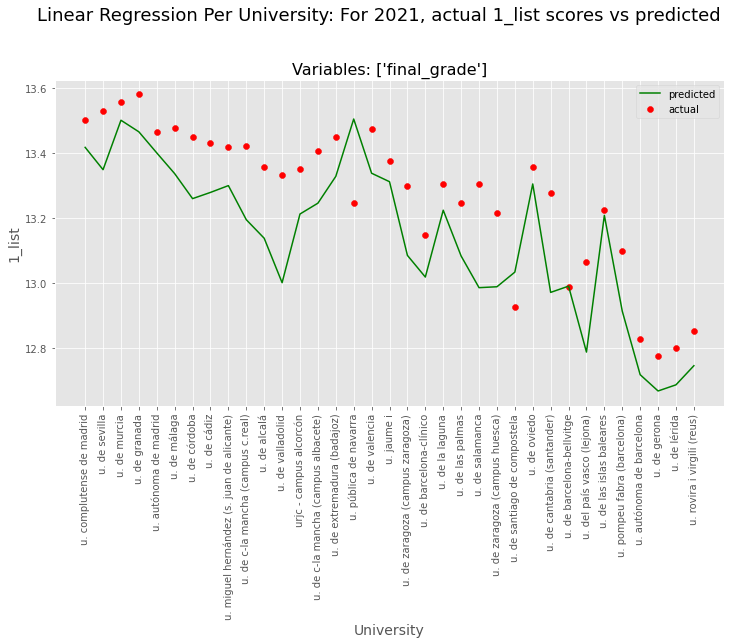

In [82]:
# using only "final_grade" variable

X_var = ['final_grade']

for uni in list_of_uni_names_2021:
    linear_regression_per_uni(X_var, 'linear_regression_per_uni_final_grade', 2021)

y_test = results_models_per_uni['y_test']
y_predict = results_models_per_uni['y_predict']

plot_actual_vs_predicted('Linear Regression Per University: For 2021, actual 1_list scores vs predicted', f'Variables: {X_var}', y_test, y_predict, 2021)

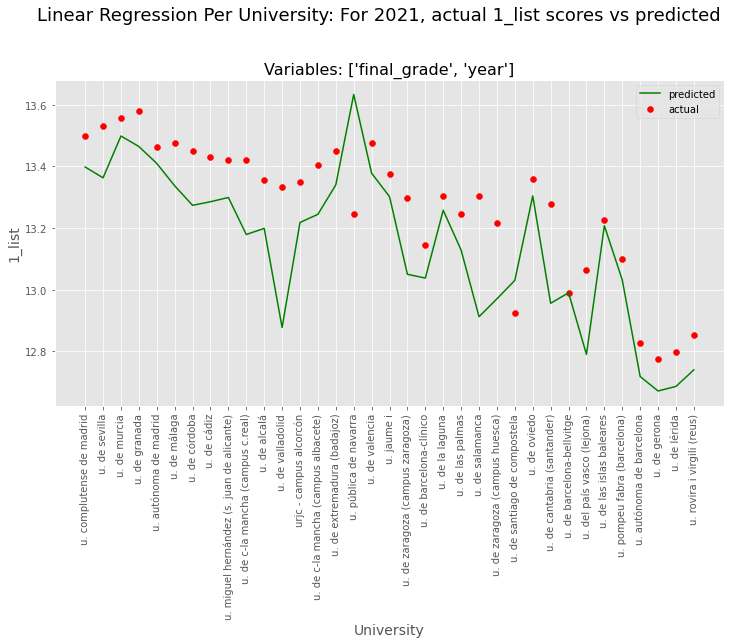

In [83]:
# using "final_grade" and "year" variables

X_var = ['final_grade', 'year']

for uni in list_of_uni_names_2021:
    linear_regression_per_uni(X_var, 'linear_regression_per_uni_final_grade_year', 2021)

y_test = results_models_per_uni['y_test']
y_predict = results_models_per_uni['y_predict']

plot_actual_vs_predicted('Linear Regression Per University: For 2021, actual 1_list scores vs predicted', f'Variables: {X_var}', y_test, y_predict, 2021)

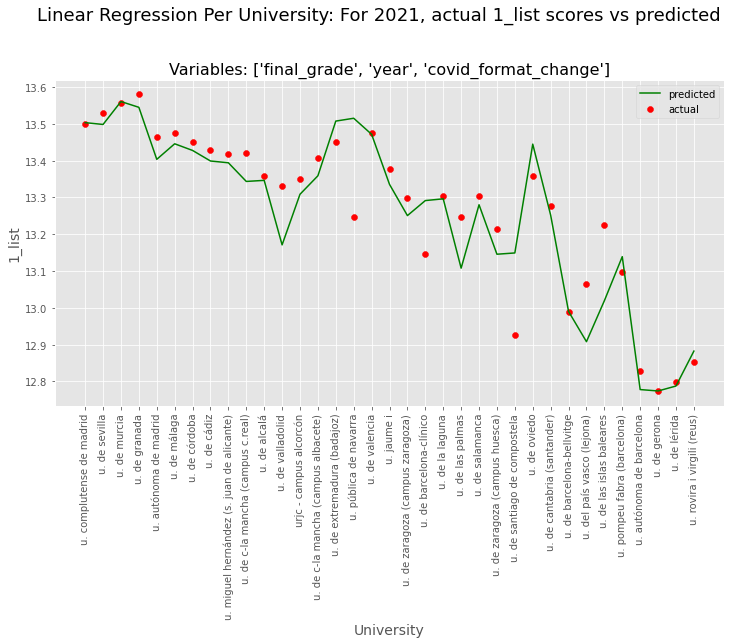

In [84]:
# using "final_grade", "year" and "covid_format_change" variables

X_var = ['final_grade', 'year', 'covid_format_change']

for uni in list_of_uni_names_2021:
    linear_regression_per_uni(X_var, 'linear_regression_per_uni_final_grade_year_covid', 2021)

y_test = results_models_per_uni['y_test']
y_predict = results_models_per_uni['y_predict']

plot_actual_vs_predicted('Linear Regression Per University: For 2021, actual 1_list scores vs predicted', f'Variables: {X_var}', y_test, y_predict, 2021)

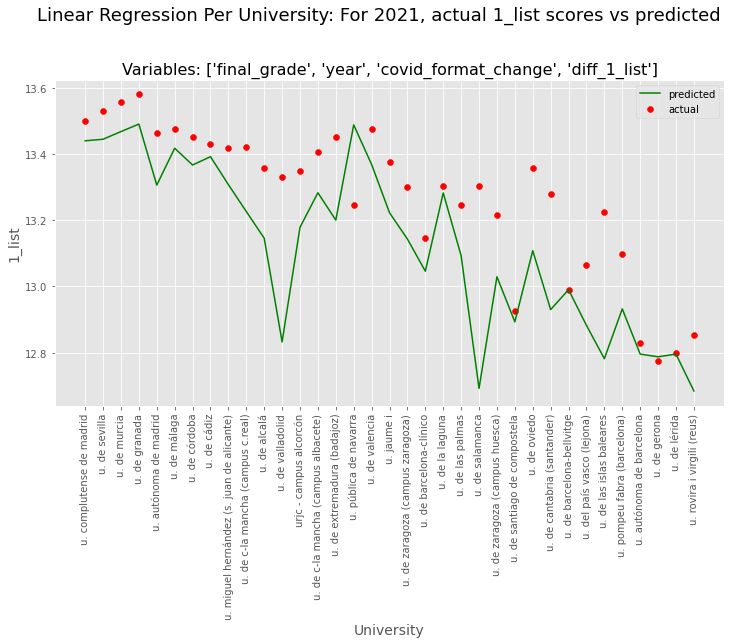

In [85]:
# using "final_grade", "year", "covid_format_change" and "diff_1_list"  variables

X_var = ['final_grade', 'year', 'covid_format_change', 'diff_1_list']

for uni in list_of_uni_names_2021:
    linear_regression_per_uni(X_var, 'linear_regression_per_uni_final_grade_year_covid_diff_1_list', 2021)

y_test = results_models_per_uni['y_test']
y_predict = results_models_per_uni['y_predict']

plot_actual_vs_predicted('Linear Regression Per University: For 2021, actual 1_list scores vs predicted', f'Variables: {X_var}', y_test, y_predict, 2021)

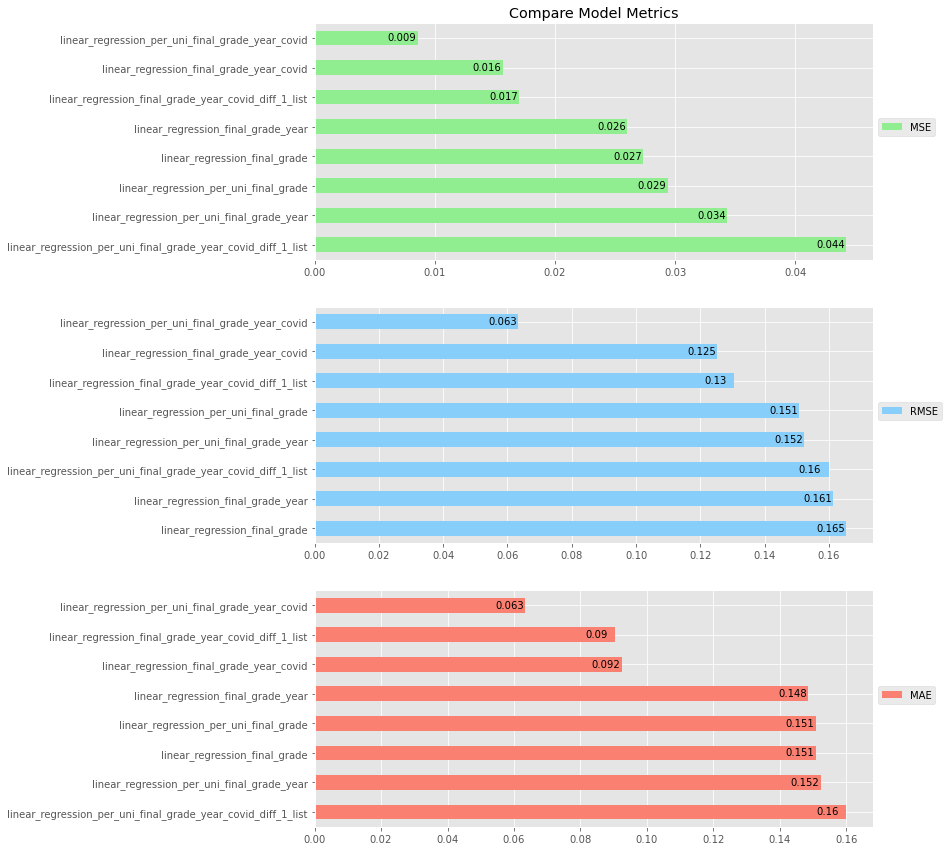

In [86]:
plot_metrics()

In [87]:
# given that the metrics are quite below the mean score of the variable we are predicting, we can consider the models are efficient

dfs_unified['1_list'].mean()

12.65742385786802

### ARIMA per University

In [88]:
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print('1. ADF: ', dftest[0])
    print('2. P-Value: ', dftest[1])
    print('3. Num Of Lags: ', dftest[2])
    print('4. Num Of Observations Used For ADF Regression and Critical Values Calculation: ', dftest[3])
    print('5. Critical Values: ')
    for key, val in dftest[4].items():
        print('\t', key, ': ', val)

In [89]:
ad_test(dfs_unified['1_list'])

1. ADF:  -2.5207859821992162
2. P-Value:  0.11049843288865308
3. Num Of Lags:  7
4. Num Of Observations Used For ADF Regression and Critical Values Calculation:  386
5. Critical Values: 
	 1% :  -3.447405233596701
	 5% :  -2.8690569369014605
	 10% :  -2.5707743450830893


We are going to first create the model with one university and afterwards we will create a function to apply it to all of the universities

In [90]:
# split data in train and test
university = 'u. complutense de madrid'
train = dfs_unified[(dfs_unified['university'] == university) & (dfs_unified['year'] != 2021) & (dfs_unified['year'] != 2011)][['1_list']]
test = dfs_unified[(dfs_unified['university'] == university) & (dfs_unified['year'] == 2021)][['1_list']]

#print(dfs_unified.shape)
print(train.shape, test.shape)

(10, 1) (1, 1)


In [91]:
dfs_unified[(dfs_unified['university'] == university)]

,year,university,1_list,final_grade,since_2010,city,CCAA,diff_1_list,diff_final_grade,diff_1_list_final_grade,covid_format_change,latitude,longitude
29,2010,u. complutense de madrid,12.189,12.022,True,madrid,C. Madrid,0.000,0.000,0.167,0.0,40.44374,-3.726146
30,2011,u. complutense de madrid,12.469,12.354,True,madrid,C. Madrid,0.280,0.332,0.115,0.0,40.44374,-3.726146
31,2012,u. complutense de madrid,12.499,12.499,True,madrid,C. Madrid,0.030,0.145,0.000,0.0,40.44374,-3.726146
29,2013,u. complutense de madrid,12.571,12.435,True,madrid,C. Madrid,0.072,-0.064,0.136,0.0,40.44374,-3.726146
30,2014,u. complutense de madrid,12.617,12.615,True,madrid,C. Madrid,0.046,0.180,0.002,0.0,40.44374,-3.726146
30,2015,u. complutense de madrid,12.697,12.697,True,madrid,C. Madrid,0.080,0.082,0.000,0.0,40.44374,-3.726146
24,2016,u. complutense de madrid,12.742,12.599,True,madrid,C. Madrid,0.045,-0.098,0.143,0.0,40.44374,-3.726146
31,2017,u. complutense de madrid,12.871,12.871,True,madrid,C. Madrid,0.129,0.272,0.000,0.0,40.44374,-3.726146
32,2018,u. complutense de madrid,12.966,12.966,True,madrid,C. Madrid,0.095,0.095,0.000,0.0,40.44374,-3.726146
32,2019,u. complutense de madrid,13.044,13.044,True,madrid,C. Madrid,0.078,0.078,0.000,0.0,40.44374,-3.726146


In [92]:
def ARIMACheck(university):
    stepwise_fit = auto_arima(dfs_unified[dfs_unified['university'] == university]['1_list'], trace=True, suppress_warnings=True)
    return stepwise_fit

In [93]:
stepwise_fit = ARIMACheck(university)
stepwise_fit

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15.292, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.626, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13.609, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.656, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.237 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [94]:
stepwise_fit.get_params().get('order')

(0, 1, 0)

In [95]:
model = ARIMA(train, order=stepwise_fit.get_params().get('order'))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 1_list   No. Observations:                   10
Model:                 ARIMA(0, 1, 0)   Log Likelihood                   2.909
Date:                Tue, 14 Jun 2022   AIC                             -3.818
Time:                        23:08:57   BIC                             -3.621
Sample:                             0   HQIC                            -4.244
                                 - 10                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0307      0.014      2.235      0.025       0.004       0.058
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.27
Prob(Q):                              0.86   Prob(JB):                         0.32
Heteroskedasticity (H):               1.43   Skew:                             1.23
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [96]:
# prediction for test set (2021 scores)
start = len(train)
end = len(train) + len(test)-1
y_predict = model.predict(start=start, end=end, typ='levels')
y_predict.index = dfs_unified[(dfs_unified['university'] == university) & (dfs_unified['year'] == 2021)]['university']
y_predict_df = y_predict.reset_index()
y_predict_df['1_list'] = ''
y_predict_df['1_list'] = y_predict_df[0]
y_predict_df = y_predict_df.drop(0, 1)
y_predict_df

,university,1_list
0,u. complutense de madrid,13.408


In [97]:
test['1_list'].values[0]

13.5

In [98]:
train['1_list'].values[0]

12.189

In [99]:
y_predict.values[0]

13.408

Let's now create a function to apply this to all of the universities

In [100]:
# df to keep track of metrics of the different ARIMA models (one per university)
arima_results_models_per_uni = pd.DataFrame(columns=['university','MSE', 'RMSE', 'MAE', 'y_predict', 'y_test'])
arima_results_models_per_uni['university'] = list_of_uni_names_2021

In [101]:
def ARIMA_per_uni(model_name_variables):
    ''' 
    create ARIMA model per university
    evaluate model with metrics MSE, RMSE, MAE
    '''
    # split data in train and test
    train = dfs_unified[(dfs_unified['university'] == uni) & (dfs_unified['year'] != 2021) & (dfs_unified['year'] != 2011)][['1_list']]
    test = dfs_unified[(dfs_unified['university'] == uni) & (dfs_unified['year'] == 2021)][['1_list']]

    stepwise_fit = ARIMACheck(uni)

    model = ARIMA(train, order=stepwise_fit.get_params().get('order'))
    model = model.fit()
    
    # prediction for test set (2021 scores)
    start = len(train)
    end = len(train) + len(test)-1
    y_predict = model.predict(start=start, end=end, typ='levels')
    y_predict = y_predict.values[0]
    y_test = test['1_list'].values[0]

    # evaluation
    errors = y_test - y_predict

    # MSE (min squared error)
    mse = np.mean(errors ** 2)

    # RMSE (root min squared error)
    rmse = np.sqrt(mse)

    # MAE (mean absolute error)
    mae = np.mean(np.abs(errors))
    
    arima_results_models_per_uni['MSE'] = np.where(arima_results_models_per_uni['university'] == uni, mse, arima_results_models_per_uni['MSE'])
    arima_results_models_per_uni['RMSE'] = np.where(arima_results_models_per_uni['university'] == uni, rmse, arima_results_models_per_uni['RMSE'])
    arima_results_models_per_uni['MAE'] = np.where(arima_results_models_per_uni['university'] == uni, mae, arima_results_models_per_uni['MAE'])
    arima_results_models_per_uni['y_predict'] = np.where(arima_results_models_per_uni['university'] == uni, y_predict, arima_results_models_per_uni['y_predict'])
    arima_results_models_per_uni['y_test'] = np.where(arima_results_models_per_uni['university'] == uni, y_test, arima_results_models_per_uni['y_test'])

    # we do the average out of all of the universities, to compare against the other models (for the metrics plot)
    results_models.loc[model_name_variables] = [model_name_variables, arima_results_models_per_uni['MSE'].mean(), arima_results_models_per_uni['RMSE'].mean(), arima_results_models_per_uni['MAE'].mean()]

In [102]:
for uni in list_of_uni_names_2021:
    print(uni)
    try:
        ARIMA_per_uni('ARIMA_per_uni')
    except:
        pass

u. complutense de madrid
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15.292, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.626, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13.609, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.656, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.228 seconds
u. de sevilla
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-15.765, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13.165, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11.191, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11.231, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.197, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercep

In [103]:
arima_results_models_per_uni

,university,MSE,RMSE,MAE,y_predict,y_test
0,u. complutense de madrid,0.008464,0.092,0.092,13.408,13.5
1,u. de sevilla,0.034611,0.18604,0.18604,13.71604,13.53
2,u. de murcia,0.013456,0.116,0.116,13.442,13.558
3,u. de granada,0.0064,0.08,0.08,13.5,13.58
4,u. autónoma de madrid,0.000882,0.029704,0.029704,13.492704,13.463
5,u. de málaga,0.008836,0.094,0.094,13.382,13.476
6,u. de córdoba,0.009025,0.095,0.095,13.355,13.45
7,u. de cádiz,0.014161,0.119,0.119,13.311,13.43
8,u. miguel hernández (s. juan de alicante),0.0121,0.11,0.11,13.309,13.419
9,u. de c-la mancha (campus c.real),0.0196,0.14,0.14,13.281,13.421


In [104]:
dfs_unified[(dfs_unified['university'] == 'u. de barcelona-bellvitge') & (dfs_unified['year'] != 2021)][['1_list']].mean()

1_list    12.99
dtype: float64

In [105]:
# for u. de barcelona-bellvitge we only have data since 2020, therefore we get an error when trying to predict the score of 2021
# for this case, let's suppose same score for 2021 as 2020

uni = 'u. de barcelona-bellvitge'
y_predict = dfs_unified[(dfs_unified['university'] == uni) & (dfs_unified['year'] != 2021)][['1_list']].mean()
y_test = dfs_unified[(dfs_unified['university'] == uni) & (dfs_unified['year'] == 2021)][['1_list']].mean()

# evaluation
errors = y_test - y_predict

# MSE (min squared error)
mse = np.mean(errors ** 2)

# RMSE (root min squared error)
rmse = np.sqrt(mse)

# MAE (mean absolute error)
mae = np.mean(np.abs(errors))
    
arima_results_models_per_uni['MSE'] = np.where(arima_results_models_per_uni['university'] == uni, mse, arima_results_models_per_uni['MSE'])
arima_results_models_per_uni['RMSE'] = np.where(arima_results_models_per_uni['university'] == uni, rmse, arima_results_models_per_uni['RMSE'])
arima_results_models_per_uni['MAE'] = np.where(arima_results_models_per_uni['university'] == uni, mae, arima_results_models_per_uni['MAE'])
arima_results_models_per_uni['y_predict'] = np.where(arima_results_models_per_uni['university'] == uni, y_predict, arima_results_models_per_uni['y_predict'])
arima_results_models_per_uni['y_test'] = np.where(arima_results_models_per_uni['university'] == uni, y_test, arima_results_models_per_uni['y_test'])

    # we do the average out of all of the universities, to compare against the other models
results_models.loc['ARIMA_per_uni'] = ['ARIMA_per_uni', arima_results_models_per_uni['MSE'].mean(), arima_results_models_per_uni['RMSE'].mean(), arima_results_models_per_uni['MAE'].mean()]

In [106]:
arima_results_models_per_uni

,university,MSE,RMSE,MAE,y_predict,y_test
0,u. complutense de madrid,0.008464,0.092,0.092,13.408,13.5
1,u. de sevilla,0.034611,0.18604,0.18604,13.71604,13.53
2,u. de murcia,0.013456,0.116,0.116,13.442,13.558
3,u. de granada,0.0064,0.08,0.08,13.5,13.58
4,u. autónoma de madrid,0.000882,0.029704,0.029704,13.492704,13.463
5,u. de málaga,0.008836,0.094,0.094,13.382,13.476
6,u. de córdoba,0.009025,0.095,0.095,13.355,13.45
7,u. de cádiz,0.014161,0.119,0.119,13.311,13.43
8,u. miguel hernández (s. juan de alicante),0.0121,0.11,0.11,13.309,13.419
9,u. de c-la mancha (campus c.real),0.0196,0.14,0.14,13.281,13.421


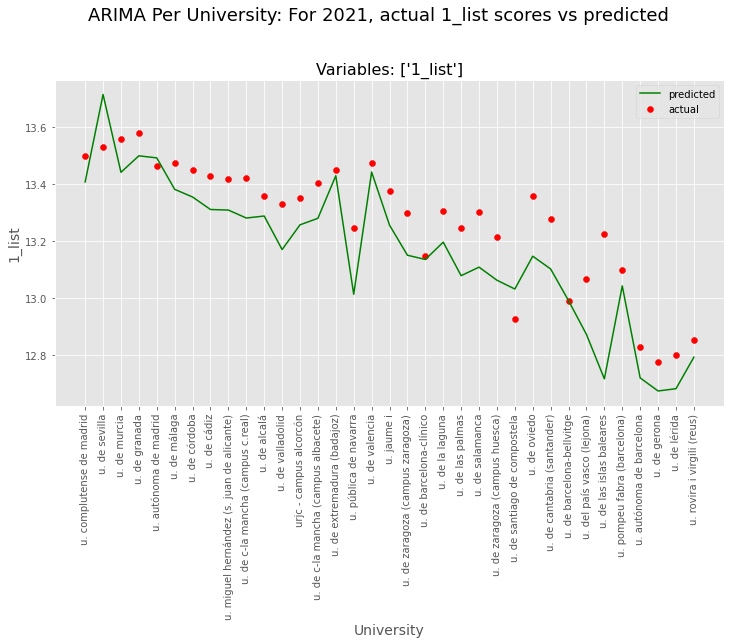

In [107]:
X_var = ['1_list']
plot_actual_vs_predicted('ARIMA Per University: For 2021, actual 1_list scores vs predicted', f'Variables: {X_var}', arima_results_models_per_uni['y_test'], arima_results_models_per_uni['y_predict'], 2021)

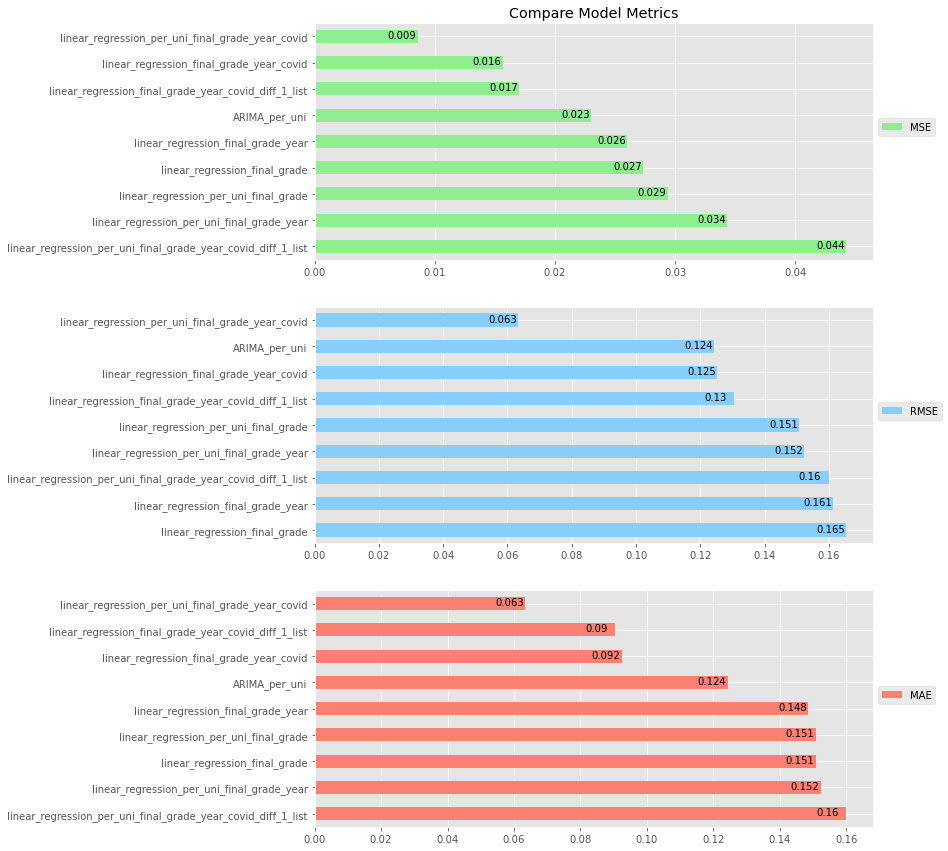

In [108]:
plot_metrics()

## Check if there is Overfitting

We are going to check two things:
- graph of predicted vs actual 1_list values for validation data (year: 2011)
- plot and compare metrics of the validation data and the test data, they should be similar

In [109]:
list_of_uni_names_2011 = dfs_unified[dfs_unified['year'] == 2011]['university'].tolist()

In [110]:
# df to keep track of metrics of the different Linear Regression models (one per university)
results_models_per_uni = pd.DataFrame(columns=['university','MSE', 'RMSE', 'MAE', 'y_predict', 'y_test'])
results_models_per_uni['university'] = list_of_uni_names_2011

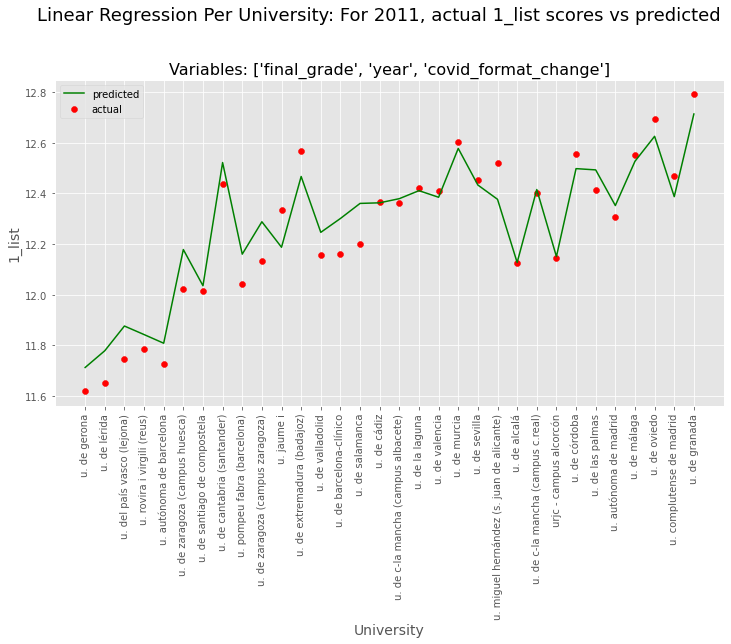

In [113]:
# using "final_grade", "year" and "covid_format_change" variables

X_var = ['final_grade', 'year', 'covid_format_change']

for uni in list_of_uni_names_2011:
    linear_regression_per_uni(X_var, 'linear_regression_per_uni_final_grade_year_covid_VALIDATION', 2011)

y_test = results_models_per_uni['y_test']
y_predict = results_models_per_uni['y_predict']

# VALIDATION DATA: year 2011
plot_actual_vs_predicted('Linear Regression Per University: For 2011, actual 1_list scores vs predicted', f'Variables: {X_var}', y_test, y_predict, 2011)

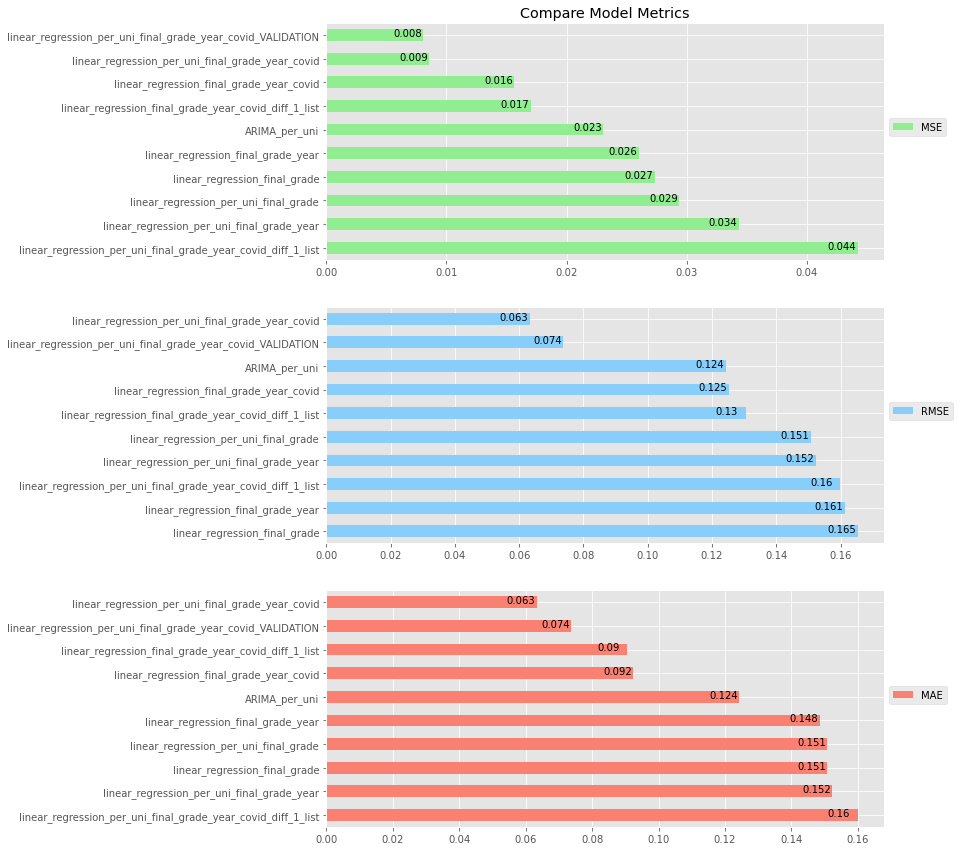

In [115]:
plot_metrics()

## Predict 2022 1_list scores

- Given the metrics results shown above, we will use the Linear Regression per University models with the variables: "final_grade", "year" and "covid_format_change" to predict the scores for 2022
- Now that we now the model is good, we retrain the model on the entire dataset (not only the train section)

In [116]:
# df of predicted scores
pred_y_df = pd.DataFrame(columns=['year', 'university', '1_list'])
pred_y_df['university'] = list_of_uni_names_2021

In [117]:
def predict_and_save_scores(year, covid_format_change, university):
    '''
    Linear Regression per university training with entire dataset
    predict scores and save them in df
    '''
    lr = LinearRegression()
    X = dfs_unified[dfs_unified['university'] == university][['final_grade', 'year', 'covid_format_change']]
    y = dfs_unified[dfs_unified['university'] == university][['1_list']]

    # train
    lr.fit(X, y)
    
    # predict, supposing final_grade as previous year's final_grade
    final_grade = dfs_unified[dfs_unified['university'] == university]['final_grade'][-1:].mean()
    
    # save predicted scores in df
    pred_y_df['1_list'] = np.where(pred_y_df['university'] == university, float(lr.predict([[final_grade, year, covid_format_change]])), pred_y_df['1_list'])

In [118]:
for uni in list_of_uni_names_2021:
    predict_and_save_scores(2022, 1.0, uni)

To get the next year (2022) “final_grade” scores we calculate them the following way: for every university, we take the predicted “1_list” score (2022) and subtracted the difference between the “1_list” and “final_grade” that the university had the previous year (2021). The formula would like this:
- “final_grade” (2022) = “1_list” (2022) – diff_1_list_final_grade (2021)

In [119]:
# final_grade score
pred_y_df['final_grade'] = ''

for uni in list_of_uni_names_2021:
    pred_y_df['final_grade'] = np.where(pred_y_df['university'] == uni, pred_y_df['1_list'] - dfs_unified[dfs_unified['university'] == uni]['diff_1_list_final_grade'][-1:].mean(), pred_y_df['final_grade'])

In [120]:
pred_y_df['year'] = 2022

In [121]:
pred_y_df

,year,university,1_list,final_grade
0,2022,u. complutense de madrid,13.540313,13.466313
1,2022,u. de sevilla,13.551518,13.366518
2,2022,u. de murcia,13.569886,13.356886
3,2022,u. de granada,13.57721,13.31621
4,2022,u. autónoma de madrid,13.466246,13.312246
5,2022,u. de málaga,13.47809,13.27709
6,2022,u. de córdoba,13.469973,13.269973
7,2022,u. de cádiz,13.452672,13.254672
8,2022,u. miguel hernández (s. juan de alicante),13.43094,13.16194
9,2022,u. de c-la mancha (campus c.real),13.436239,13.161239


In [122]:
# append predicted scores to dfs_unified
dfs_unified = dfs_unified.append(pred_y_df)

In [123]:
dfs_unified

,year,university,1_list,final_grade,since_2010,city,CCAA,diff_1_list,diff_final_grade,diff_1_list_final_grade,covid_format_change,latitude,longitude
0,2010,u. de lérida,11.654,11.04,True,lérida,Cataluña,0.0,0.0,0.614,0.0,41.816361,1.597137
1,2010,u. de gerona,11.61,11.07,True,gerona,Cataluña,0.0,0.0,0.540,0.0,41.974379,2.823543
2,2010,u. rovira i virgili (reus),11.708,11.142,True,reus,Cataluña,0.0,0.0,0.566,0.0,41.155309,1.105327
3,2010,u. de zaragoza (campus huesca),12.059,11.19,True,huesca,Aragón,0.0,0.0,0.869,0.0,42.141406,-0.406090
4,2010,u. autónoma de barcelona,11.59,11.195,True,barcelona,Cataluña,0.0,0.0,0.395,0.0,41.502593,2.080056
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,2022,u. pompeu fabra (barcelona),13.174329,12.834329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,2022,u. autónoma de barcelona,12.804136,12.727136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,2022,u. de gerona,12.783829,12.726829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,2022,u. de lérida,12.81147,12.72347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
# apply created columns to predicted data (2022)
since_2010()
city()
CCAA()
covid_format_change()
diff_between_years('diff_1_list', '1_list')
diff_between_years('diff_final_grade', 'final_grade')
diff_1_list_final_grade()
round_to_3()
latitude()
longitude()

Predicted scores (2022)

In [125]:
dfs_unified[dfs_unified['year'] == 2022]

,year,university,1_list,final_grade,since_2010,city,CCAA,diff_1_list,diff_final_grade,diff_1_list_final_grade,covid_format_change,latitude,longitude
0,2022,u. complutense de madrid,13.540,13.466,True,madrid,C. Madrid,0.040,0.040,0.074,1.0,40.44374,-3.726146
1,2022,u. de sevilla,13.552,13.367,True,sevilla,Andalucía,0.022,0.022,0.185,1.0,37.412856,-5.984561
2,2022,u. de murcia,13.570,13.357,True,murcia,Murcia,0.012,0.012,0.213,1.0,37.991092,-1.130104
3,2022,u. de granada,13.577,13.316,True,granada,Andalucía,-0.003,-0.003,0.261,1.0,37.147441,-3.604235
4,2022,u. autónoma de madrid,13.466,13.312,True,madrid,C. Madrid,0.003,0.003,0.154,1.0,40.483226,-3.697226
5,2022,u. de málaga,13.478,13.277,True,málaga,Andalucía,0.002,0.002,0.201,1.0,36.720043,-4.416179
6,2022,u. de córdoba,13.470,13.270,True,córdoba,Andalucía,0.020,0.020,0.200,1.0,37.856042,-4.813445
7,2022,u. de cádiz,13.453,13.255,True,cádiz,Andalucía,0.023,0.023,0.198,1.0,36.53402,-6.301899
8,2022,u. miguel hernández (s. juan de alicante),13.431,13.162,True,alicante,C. Valenciana,0.012,0.012,0.269,1.0,38.398963,-0.434778
9,2022,u. de c-la mancha (campus c.real),13.436,13.161,True,ciudad real,Castilla-La Mancha,0.015,0.015,0.275,1.0,38.991837,-3.926826


# Export data

In [126]:
exported_data_directory = your_directory + '/output'
exported_data_directory

'/Users/miguel/output'

In [127]:
# export data to be used on streamlit
file_name = exported_data_directory + '/exported_data_notebook.csv'
dfs_unified.to_csv(file_name, index = False, header=True)